In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Выведем информацию по типам в данном датасете

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


В данном датасете 8 признаков:
Категориальные признаки:
1. Description - описание товара
2. Country - Страна, из которой совершалась покупка
3. InvoiceDate - дата заказа
4. InvoiceNo - номер заказа
5. StockCode - код товара
6. CustomerID - ID клиента

Количественные признаки:
1. Quantity - количество товара
2. UnitPrice - цена одной единицы товара

Посмотрим количество строк в датасете

In [5]:
df.shape

(541909, 8)

Исследуем датасет на пропуски в столбцах

In [6]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Удалим пропуски, так как нам необхобимо работать с полными данными

In [7]:
df = df.dropna(subset=['CustomerID','Description'])
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Проведем анализ количества покупок в магазине

In [8]:
df['Quantity'].unique()

array([     6,      8,      2,     32,      3,      4,     24,     12,
           48,     18,     20,     36,     80,     64,     10,    120,
           96,     23,      5,      1,     -1,     50,     40,    100,
          192,    432,    144,    288,    -12,    -24,     16,      9,
          128,     25,     30,     28,      7,     72,    200,    600,
          480,     -6,     14,     -2,     -4,     -5,     -7,     -3,
           11,     70,    252,     60,    216,    384,     27,    108,
           52,  -9360,     75,    270,     42,    240,     90,    320,
           17,   1824,    204,     69,    -36,   -192,   -144,    160,
         2880,   1400,     19,     39,    -48,    -50,     56,     13,
         1440,     -8,     15,    720,    -20,    156,    324,     41,
          -10,    -72,    -11,    402,    378,    150,    300,     22,
           34,    408,    972,    208,   1008,     26,   1000,    -25,
         1488,    250,   1394,    400,    110,    -14,     37,    -33,
      

Скорее всего, отрицательными значениями являются возвраты. Составим отдельный датасет из возвратов и очистим текущий от них

In [9]:
df_back = df[df['Quantity'] <= 0]
df = df[df['Quantity'] > 0]
# переделаем тип данных столбца CustomerID на int
df['CustomerID'] = df['CustomerID'].astype(int)

Теперь посмотрим на выбросные значения по стоимости заказов. Выбросными значениями будем считать значения, которые не попадают в интервал   
[1 квартиль - 1,5 * IQR; 3 квартиль + 1,5 * IQR], где IQR - межквартильный размах.

In [10]:
#Формируем датасет стоимости заказов
df['Total_Price'] = df['Quantity'] * df['UnitPrice']
invoices_pricelist = df.groupby('InvoiceNo')['Total_Price'].sum().reset_index()
invoices_pricelist.head()

,InvoiceNo,Total_Price
0,536365,139.12
1,536366,22.20
2,536367,278.73
3,536368,70.05
4,536369,17.85


In [11]:
q_1 = invoices_pricelist['Total_Price'].quantile(0.25)
q_3 = invoices_pricelist['Total_Price'].quantile(0.75)
IQR = q_3 - q_1

upper = q_3 + 1.5*IQR
lower = q_1 - 1.5*IQR

outliers = invoices_pricelist[(invoices_pricelist['Total_Price'] < lower) | (invoices_pricelist['Total_Price'] > upper)]
len(outliers)

1466

 Как мы видим, в данном датасете 1466 выбросов. Посмотрим, как это выглядит на графике

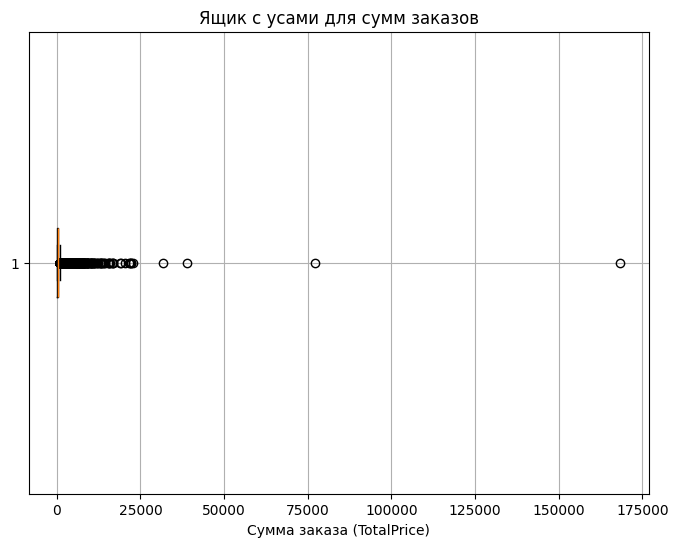

In [12]:
plt.figure(figsize=(8,6))
plt.boxplot(invoices_pricelist['Total_Price'], vert=False)
plt.title('Ящик с усами для сумм заказов')
plt.xlabel('Сумма заказа (TotalPrice)')
plt.grid(True)

In [13]:
invoices_pricelist['Total_Price'].max()

np.float64(168469.6)

Очень большое скопление выбросов, можно посмотреть на распределение заказов на столбчатой диаграмме

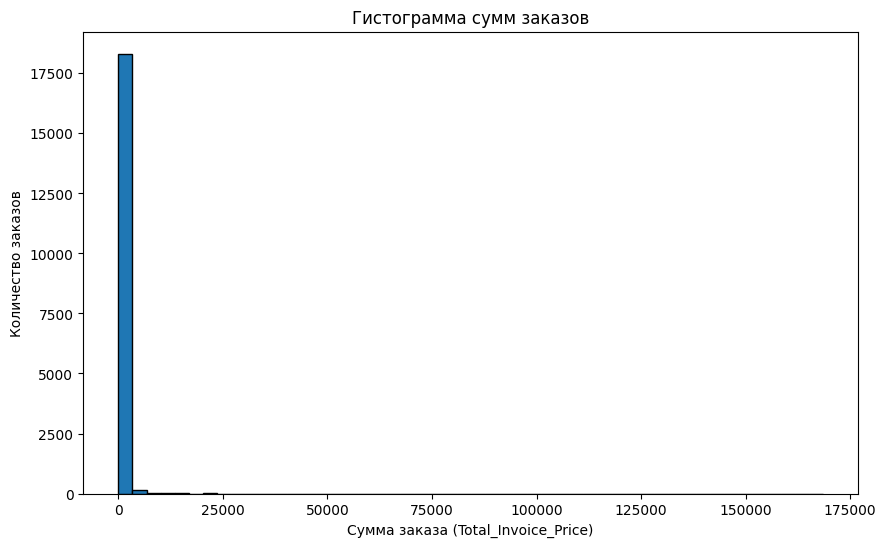

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(invoices_pricelist['Total_Price'], bins=50, edgecolor='black')
plt.title('Гистограмма сумм заказов')
plt.xlabel('Сумма заказа (Total_Invoice_Price)')
plt.ylabel('Количество заказов')
plt.show()

Из графика видно точно, что самое большое скопление заказов на небольшие суммы, поэтому нужно избавиться от больших заказов. Но для начала посмотрим как гистограмма выглядит на промежутке от 0 до 250000

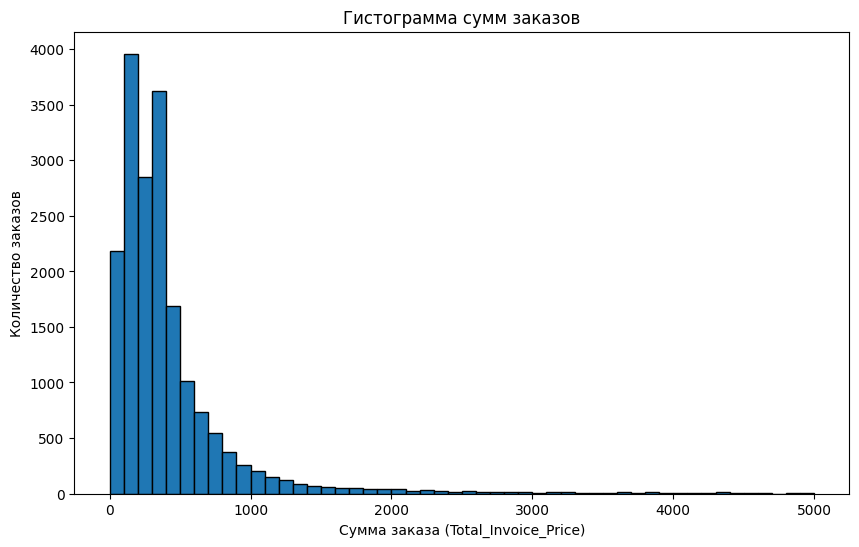

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(invoices_pricelist['Total_Price'], bins=50, range=(0, 5000), edgecolor='black')
plt.title('Гистограмма сумм заказов')
plt.xlabel('Сумма заказа (Total_Invoice_Price)')
plt.ylabel('Количество заказов')
plt.show()

как видно из гистограммы выше, большая часть заказов имеет стоимость ниже 1000. Теперь же избавимся наконец от выбросных значений.

In [16]:
invoices_pricelist = invoices_pricelist[(invoices_pricelist['Total_Price'] >= lower) & (invoices_pricelist['Total_Price'] <= upper)]

Теперь посмотрим, как распределились данные

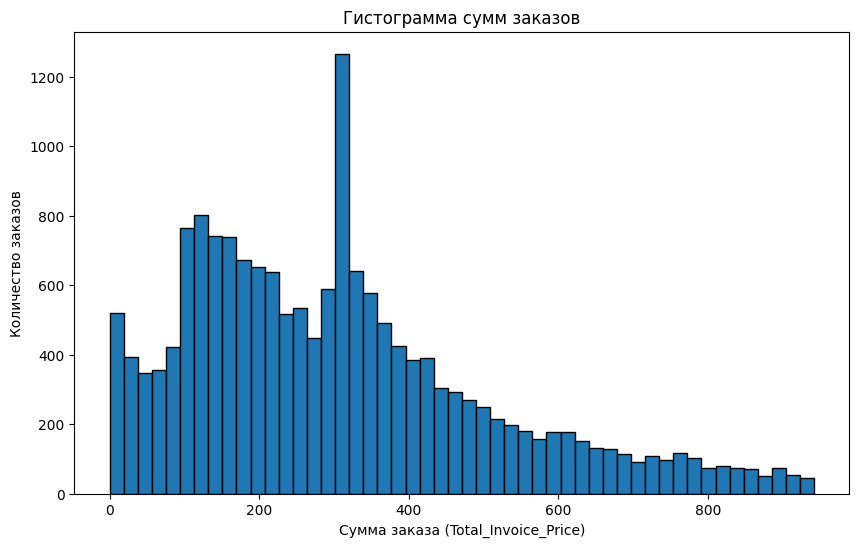

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(invoices_pricelist['Total_Price'], bins=50, edgecolor='black')
plt.title('Гистограмма сумм заказов')
plt.xlabel('Сумма заказа (Total_Invoice_Price)')
plt.ylabel('Количество заказов')
plt.show()

Данные подготовлены, идем дальше

## Расчет основных показателей/метрик

Какие метрики будем считать

- Общая выручка (сумма всех заказов).
- Средний чек (средняя сумма заказа).
- Топ-5 продуктов (по количеству проданных единиц).
- Топ-5 стран.
- Доля повторных клиентов (Retention Rate).

Общая выручка:

In [18]:
#с выбросами
revenue_v = df['Total_Price'].sum()
revenue_v

np.float64(8911407.904)

In [19]:
#без них
revenue_s = invoices_pricelist['Total_Price'].sum()
revenue_s

np.float64(5217243.823000001)

Средний чек:

In [20]:
invoices_pricelist['Total_Price'].mean()

np.float64(305.6381852958407)

Топ-5 продуктов (по количеству проданных единиц):

In [21]:
df.groupby('Description')['Quantity'].sum().sort_values(ascending=False)

Description
PAPER CRAFT , LITTLE BIRDIE            80995
MEDIUM CERAMIC TOP STORAGE JAR         77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS      54415
JUMBO BAG RED RETROSPOT                46181
WHITE HANGING HEART T-LIGHT HOLDER     36725
                                       ...  
BLACK VINT ART DEC CRYSTAL BRACELET        1
FLOWER SHOP DESIGN MUG                     1
SET 36 COLOURING PENCILS DOILEY            1
HEN HOUSE W CHICK IN NEST                  1
AMBER BERTIE GLASS BEAD BAG CHARM          1
Name: Quantity, Length: 3877, dtype: int64

Топ-5 продуктов по количеству проданных единиц


1. PAPER CRAFT , LITTLE BIRDIE            
2. MEDIUM CERAMIC TOP STORAGE JAR         
3. WORLD WAR 2 GLIDERS ASSTD DESIGNS      
4. JUMBO BAG RED RETROSPOT               
5. WHITE HANGING HEART T-LIGHT HOLDER     

## Топ-5 стран 

In [22]:
invoice_countries = df[['InvoiceNo', 'Country']].drop_duplicates()
invoices_pricelist = invoices_pricelist.merge(invoice_countries, on='InvoiceNo', how='left')

In [23]:
invoices_pricelist.groupby('Country')['Total_Price'].mean().sort_values(ascending=False)

Country
Malta                   545.118000
Greece                  524.820000
Iceland                 502.613333
USA                     500.220000
EIRE                    483.388610
Switzerland             477.342432
United Arab Emirates    463.370000
Denmark                 441.937500
Finland                 432.043947
Austria                 426.758462
Czech Republic          413.370000
Channel Islands         409.879375
Cyprus                  408.234545
Portugal                396.275652
Norway                  393.614583
France                  369.888517
Belgium                 367.652717
Spain                   364.216618
Australia               362.500652
Poland                  352.927778
Germany                 350.924749
Unspecified             333.383750
European Community      325.062500
Canada                  319.320000
Netherlands             308.940588
Israel                  305.710000
Italy                   305.419688
United Kingdom          298.405778
Sweden      

In [24]:
invoices_pricelist[invoices_pricelist['Country'] == 'Malta']

,InvoiceNo,Total_Price,Country
7173,555931,833.16,Malta
7813,557668,30.00,Malta
9959,563353,905.50,Malta
10208,563936,213.50,Malta
15161,576897,743.43,Malta


In [25]:
invoices_pricelist['Country'].value_counts()

Country
United Kingdom          15555
Germany                   398
France                    344
EIRE                      187
Belgium                    92
Spain                      68
Netherlands                51
Portugal                   46
Australia                  46
Finland                    38
Switzerland                37
Italy                      32
Sweden                     26
Norway                     24
Poland                     18
Channel Islands            16
Austria                    13
Denmark                    12
Cyprus                     11
Unspecified                 8
Japan                       8
Iceland                     6
Malta                       5
Greece                      4
Canada                      4
USA                         4
European Community          4
Israel                      3
Lithuania                   3
Czech Republic              2
Bahrain                     2
United Arab Emirates        2
Saudi Arabia                1
Na

In [26]:
len(invoices_pricelist['Country'].unique())

33

In [27]:
enough_orders = invoices_pricelist['Country'].value_counts()
countries_with_enough_orders = enough_orders[enough_orders > 12.5].index

In [28]:
invoices_filtered = invoices_pricelist[invoices_pricelist['Country'].isin(countries_with_enough_orders)]

In [29]:
invoices_filtered['Country'].value_counts()

Country
United Kingdom     15555
Germany              398
France               344
EIRE                 187
Belgium               92
Spain                 68
Netherlands           51
Australia             46
Portugal              46
Finland               38
Switzerland           37
Italy                 32
Sweden                26
Norway                24
Poland                18
Channel Islands       16
Austria               13
Name: count, dtype: int64

In [30]:
invoices_filtered.groupby('Country')['Total_Price'].mean().sort_values(ascending=False)

Country
EIRE               483.388610
Switzerland        477.342432
Finland            432.043947
Austria            426.758462
Channel Islands    409.879375
Portugal           396.275652
Norway             393.614583
France             369.888517
Belgium            367.652717
Spain              364.216618
Australia          362.500652
Poland             352.927778
Germany            350.924749
Netherlands        308.940588
Italy              305.419688
United Kingdom     298.405778
Sweden             289.958077
Name: Total_Price, dtype: float64

Я убрал страны, сумма заказов в которых меньше медианного значения (12.5). Из анализа выше мы можем составить топ-5 стран по среднему чеку и по количеству заказов:

Топ-5 по среднему чеку

1. EIRE              со средним чеком =            483.39
2. Switzerland       со средним чеком =       477.34
3. Finland           со средним чеком =       432.04
4. Austria           со средним чеком =       426.76
5. Channel Islands   со средним чеком =   409.88

Топ-5 по количеству заказов:

1. United Kingdom   с количеством заказов =   15555
2. Germany    с количеством заказов =           398
3. France      с количеством заказов =          344
4. EIRE        с количеством заказов =          187
5. Belgium     с количеством заказов =           92

## Доля повторных клиентов

Расчитаем долю повторных клиентов в интернет-магазине

In [31]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34


In [32]:
customer_orders = df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_orders

CustomerID
12346     1
12347     7
12348     4
12349     1
12350     1
         ..
18280     1
18281     1
18282     2
18283    16
18287     3
Name: InvoiceNo, Length: 4339, dtype: int64

In [33]:
repeat_customers = (customer_orders > 1).sum()

In [34]:
repeat_customers

np.int64(2845)

In [35]:
total_customers = customer_orders.count()
total_customers

np.int64(4339)

In [36]:
share_of_repeat_customers = repeat_customers / total_customers * 100
share_of_repeat_customers

np.float64(65.56810324959667)

Доля повторных клиентов магазина - 65,57 %

## Когортный анализ

Цель: Когортный анализ поможет понять, как клиенты возвращаются для повторных покупок с течением времени. 
Я сгруппирую клиентов по дате их первой покупки (когорта) и посмотрю, 
как их поведение (например, количество заказов или выручка) меняется в последующие месяцы.

1. Определим когорты:
- Когорта — это группа клиентов, сделавших первую покупку в одном и том же месяце.
2. Посчитаем метрики:
- Доля клиентов, которые возвращаются в последующие месяцы (Retention Rate по месяцам).
- (Бонус) Средний чек или выручка по когортам.
3. Визуализируем:
- Построим тепловую карту (heatmap) для Retention Rate.

In [37]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34


In [38]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
#определим месяц первой покупки для каждого клиента
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12


In [39]:
df['CohortIndex'] = (df['InvoiceMonth'] - df['CohortMonth']).apply(lambda x: x.n)

Получается, эти разности дат порождают объекты, которые состоят из разности в месяцах (так как мы вытягиваем из дат период месяц) между этими датами, а с помощью метода .n мы берем само число разности между этими датами

In [40]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12,2010-12,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12,2010-12,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12,0


In [41]:
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_sizes = cohort_counts[0]

retention = cohort_counts.divide(cohort_sizes, axis=0)
retention = retention.round(3) * 100
retention

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


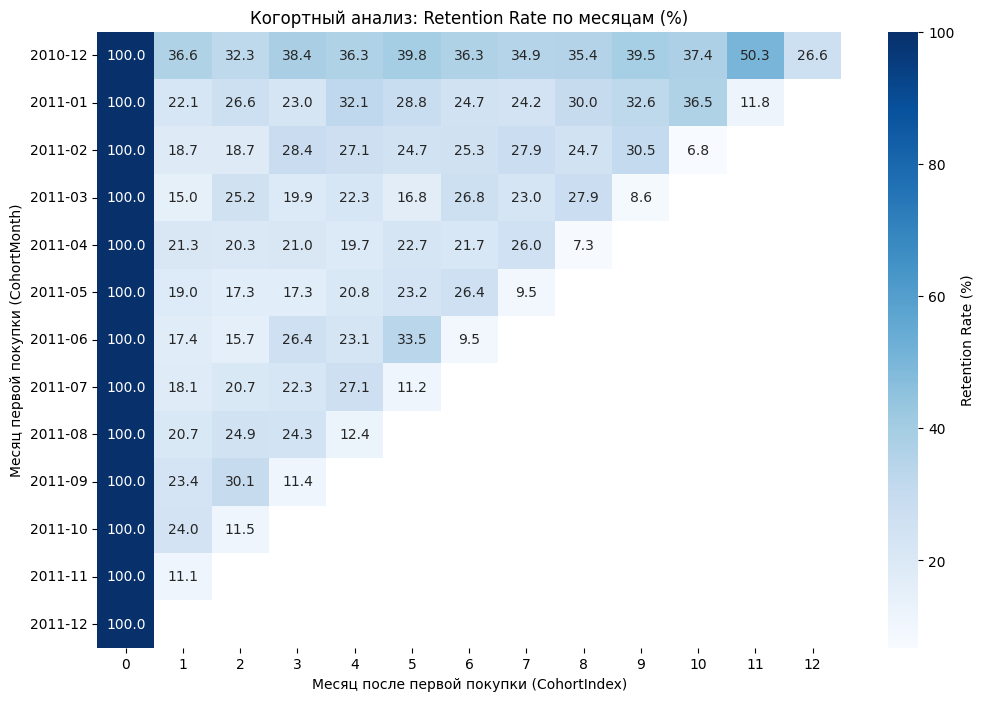

In [42]:

plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': 'Retention Rate (%)'})
plt.title('Когортный анализ: Retention Rate по месяцам (%)')
plt.xlabel('Месяц после первой покупки (CohortIndex)')
plt.ylabel('Месяц первой покупки (CohortMonth)')
plt.savefig('cohort_retention_heatmap.png')
plt.show()

### Выводы

* Общая выручка магазина: 8911407
* общая выручка без оптовых закупок: 5217243
* Средний чек в магазине: 305.6
* Доля клиентов, которые совершили повторный заказ: 65,57 %

#### Топ-5 по количеству заказов:

* United Kingdom с количеством заказов = 15555
* Germany с количеством заказов = 398
* France с количеством заказов = 344
* EIRE с количеством заказов = 187
* Belgium с количеством заказов = 92

## Анализ возвратов

Перейдем к анализу возвратов в магазине

In [43]:
df_back.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


Посмотрим объем возвратов и их долю от всех транзакций в магазине

In [45]:
backs = len(df_back)
total_trans = len(df) + backs
part = backs / total_trans * 100
part

2.188880340388714

Доля возвратов на весь магазин = 2.19%, что не очень существенно, теперь посмотрим, сколько магазин потерял денег от возвратов

In [53]:
discounts = df_back[df_back['StockCode'] == 'D']
discounts.count()

InvoiceNo      77
StockCode      77
Description    77
Quantity       77
InvoiceDate    77
UnitPrice      77
CustomerID     77
Country        77
Total_Price     0
dtype: int64

In [54]:
# исключим скидки на товары
df_back = df_back[df_back['StockCode'] != 'D']

In [56]:
df_back['Total_Price'] = df_back['Quantity'] * df_back['UnitPrice']
df_back.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,Total_price
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,-4.65,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,-19.80,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96,-6.96
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96,-6.96


In [59]:
df_back = df_back.drop('Total_price',axis=1)
df_back.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96


In [62]:
miss = df_back['Total_Price'].sum()

Магазин с возвратов потерял 605645,87 единиц денег


In [64]:
abs(miss) / revenue_s * 100

np.float64(11.60854064995076)

В процентном соотношении, на возвратах магазин потерял 11% от текущей выручки. Это очень много!

Посмотрим лидеры товаров по возвратам

In [74]:
returns = df_back.groupby('Description')['Quantity'].sum().sort_values().reset_index()
returns.head()

,Description,Quantity
0,"PAPER CRAFT , LITTLE BIRDIE",-80995
1,MEDIUM CERAMIC TOP STORAGE JAR,-74494
2,ROTATING SILVER ANGELS T-LIGHT HLDR,-9367
3,Manual,-3995
4,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3150


Выше представлен топ-5 самых возвращаемых товаров магазина. Возможно, необходимо снизить на них стоимость, чтобы предотвратить такой массовый возврат, либо проблемы в качестве товара. Необходимо провести его диагностику и ознакомиться с отзывами покупателей.

Посмотрим, есть ли клиенты с аномальным количеством возвратов

In [77]:
returns_clients = df_back.groupby('CustomerID')['Quantity'].sum().sort_values().reset_index()
returns_clients

,CustomerID,Quantity
0,16446.0,-80995
1,12346.0,-74215
2,15838.0,-9360
3,15749.0,-9014
4,16029.0,-8007
...,...,...
1580,13154.0,-1
1581,16428.0,-1
1582,16419.0,-1
1583,13141.0,-1


In [78]:
returns_clients.describe()

,CustomerID,Quantity
count,1585.000000,1585.000000
mean,15187.145110,-172.627129
std,1723.325841,2792.976815
min,12346.000000,-80995.000000
25%,13717.000000,-26.000000
50%,15140.000000,-8.000000
75%,16669.000000,-3.000000
max,18282.000000,-1.000000


- В среднем на 1 клиента приходится 8 возвратов, что очень много, возможно, стоит задуматься о качестве продукции магазина.
- Клиенты с аномальным количеством возвратов, скорее всего, являются оптовыми закупщиками, с которыми необходимо связаться для уточнения деталей возврата.

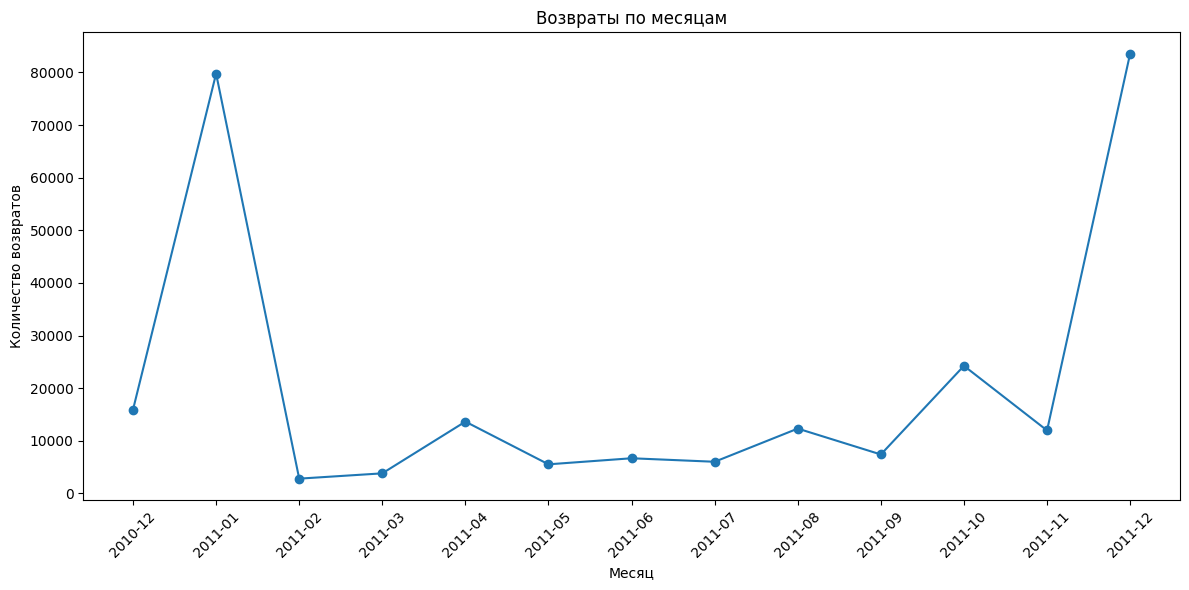

In [79]:

df_back['InvoiceDate'] = pd.to_datetime(df_back['InvoiceDate'])


df_back['YearMonth'] = df_back['InvoiceDate'].dt.to_period('M')


returns_by_month = df_back.groupby('YearMonth')['Quantity'].sum().reset_index()
returns_by_month['Quantity'] = returns_by_month['Quantity'].abs()


plt.figure(figsize=(12, 6))
plt.plot(returns_by_month['YearMonth'].astype(str), returns_by_month['Quantity'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Месяц')
plt.ylabel('Количество возвратов')
plt.title('Возвраты по месяцам')
plt.tight_layout()
plt.savefig('returns_by_month.png')
plt.show()

Декабрь:

Декабрь — это пик предпраздничных покупок, особенно перед Рождеством и Новым годом. Клиенты часто покупают подарки, что увеличивает объем продаж.
Возвраты в декабре могут быть связаны с:
- Ошибками в заказах (например, клиент заказал не тот товар в спешке).
- Проблемами с доставкой (логистические задержки из-за высокого спроса).
- Повреждением товаров во время доставки из-за перегрузки курьерских служб.


Январь:

Январь — это период после праздников, когда клиенты возвращают подарки, которые не подошли, или товары, купленные в декабре.
Возвраты в январе могут быть вызваны:
- Несоответствием ожиданиям (например, подарок не понравился получателю).
- Дефектными товарами, выявленными после использования.